# Library
---
*Import library* yang diperlukan dalam Proyek Rekomendasi Buku (*Content-Based Filtering*).

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Exploratory Data Analysis (EDA)
---

## Gathering Data
Mengumpulkan data-data yang diperlukan, di dalam proyek ini terdapat tiga buah dataset yang dapat digunakan yaitu:
- Books.csv
- Ratings.csv
- Users.csv

Ketiga dataset tersebut akan disimpan ke dalam tiga variabel berbeda yaitu `books`, `ratings`, dan `users`.

In [75]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')

/tmp/ipykernel_28/409789061.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')


Membuat dataframe baru untuk menggabungkan ketiga dataset dengan nama `merged_df`.

In [76]:
merged_df = pd.merge(ratings, books, on='ISBN')
merged_df = pd.merge(merged_df, users, on='User-ID')
merged_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,"cincinnati, ohio, usa",23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,276442,2862749796,7,Le Huit,Katherine Neville,2002,Le Cherche Midi,http://images.amazon.com/images/P/2862749796.0...,http://images.amazon.com/images/P/2862749796.0...,http://images.amazon.com/images/P/2862749796.0...,"genève, genève, switzerland",62.0
1031132,276618,3788097000,5,Ludwig Marum: Briefe aus dem Konzentrationslag...,Ludwig Marum,1984,C.F. MÃ¼ller,http://images.amazon.com/images/P/3788097000.0...,http://images.amazon.com/images/P/3788097000.0...,http://images.amazon.com/images/P/3788097000.0...,"stuttgart, \n/a\""., germany""",NaN
1031133,276647,0553571001,0,Christmas With Anne and Other Holiday Stories:...,L. M. Montgomery,2001,Starfire,http://images.amazon.com/images/P/0553571001.0...,http://images.amazon.com/images/P/0553571001.0...,http://images.amazon.com/images/P/0553571001.0...,"arlington heights, illinois, usa",13.0
1031134,276647,0689822294,10,Heaven (Coretta Scott King Author Award Winner),Angela Johnson,1998,Simon &amp; Schuster Children's Publishing,http://images.amazon.com/images/P/0689822294.0...,http://images.amazon.com/images/P/0689822294.0...,http://images.amazon.com/images/P/0689822294.0...,"arlington heights, illinois, usa",13.0


Tampilkan lima data paling atas dari ketiga dataset tersebut menggunakan fungsi `head()`.

In [77]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Setelah menjalankan kode di atas, dapat dilihat bahwa dataset `Books.csv` memiliki kolom:
- ISBN: Kode unik dari sebuah buku
- Book-Title: Judul buku
- Book-Author: Pengarang buku
- Year-Of-Publication: Tahun terbit buku
- Publisher: Penerbit buku
- Image-URL-S: Cover buku berukuran kecil
- Image-URL-M: Cover buku berukuran sedang
- Image-URL-L: Cover buku berukuran besar

In [78]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Setelah menjalankan kode di atas, dapat dilihat bahwa dataset `Ratings.csv` memiliki kolom:
- User-ID: Kode unik dari pengguna yang memberikan penilaian
- ISBN: Kode unik dari sebuah buku
- Book-Rating: Penilaian buku nilai terendah dimulai dari angka 0

In [79]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Setelah menjalankan kode di atas, dapat dilihat bahwa dataset `Users.csv` memiliki kolom:
- User-ID: Kode unik dari pengguna
- Location: Lokasi pengguna
- Age: Usia pengguna

Hal menarik yang dapat dilihat dari dataset `Users.csv` terdapat banyak *missing value* yang akan ditangani selanjutnya.
Sebelum itu, mari kita lihat jumlah keseluruhan buku, rating, dan user pada proyek kali ini.

In [80]:
print('Jumlah keseluruhan buku: ', len(books.ISBN.unique()))
print('Jumlah keseluruhan rating: ', len(ratings[['ISBN', 'User-ID']].drop_duplicates()))
print('Jumlah keseluruhan user: ', len(users['User-ID'].unique()))

Jumlah keseluruhan buku:  271360
Jumlah keseluruhan rating:  1149780
Jumlah keseluruhan user:  278858


In [81]:
print('Shape dataframe buku: ', books.shape)
print('Shape dataframe rating: ', ratings.shape)
print('Shape dataframe user: ', users.shape)

Shape dataframe buku:  (271360, 8)
Shape dataframe rating:  (1149780, 3)
Shape dataframe user:  (278858, 3)


Gunakan fungsi `info()` untuk mengetahui informasi penting seperti tipe data yang digunakan pada proyek kali ini.

In [82]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Setelah menjalankan kode di atas, dapat dilihat bahwa seluruh kolom pada dataset `Books.csv` memiliki tipe data *object*.
Ada hal unik yang didapati ketika menjalankan kode di atas, dapat dilihat bahwa kolom `Year-Of-Publication` bertipe data *object* sedangkan tahun publikasi umumnya bertipe data integer, oleh karena itu akan dilakukan perbaikan tipe data.

## Mengubah Tipe Data

In [83]:
## Ketika menjalankan kode di bawah ini muncul ValueError: invalid literal for int() with base 10: 'DK Publishing Inc'
## Artinya value pada `Year-Of-Publication` ada yang bernilai 'DK Publishing Inc'. Sepertinya terdapat kesalahan input.
# books['Year-Of-Publication'].astype('int')

In [84]:
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


Membuang value pada `Year-Of-Publication` ada yang bernilai 'DK Publishing Inc' dan 'Gallimard'.

In [85]:
temp = (books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')
books = books.drop(books[temp].index)
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


Mengubah tipe data pada `Year-Of-Publication`.

In [86]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
print(books.dtypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


Tipe data pada kolom `Year-Of-Publication` sudah menjadi integer.

In [87]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Setelah menjalankan kode di atas, dapat dilihat bahwa kolom `User-ID` dan `Book-Rating` pada dataset `Ratings.csv` memiliki tipe data *integer* sedangkan kolom `ISBN` bertipe *object*.

In [88]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Setelah menjalankan kode di atas, dapat dilihat bahwa kolom-kolom pada `Ratings.csv` memiliki tipe data sebagai berikut:
- `User-ID` bertipe integer
- `Location` bertipe object
- `Age` bertipe desimal

## Distribusi Data

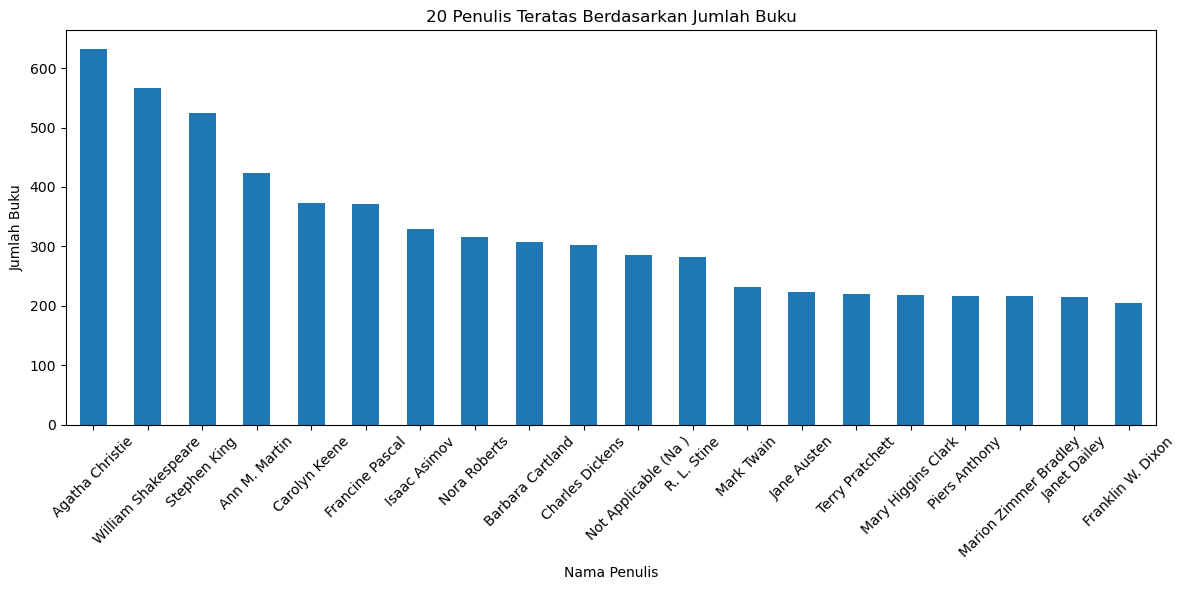

In [89]:
# Grouping'Book-Author' dan hitung jumlah buku yang ditulis oleh masing-masing penulis
author_counts = books.groupby('Book-Author')['Book-Title'].count()
# Urutkan penulis dalam urutan menurun
sorted_authors = author_counts.sort_values(ascending=False)
# Pilih 20 penulis teratas
top_20_authors = sorted_authors.head(20)
# Plot 20 penulis teratas dan buku yang ditulis oleh penulis kemudian dihitung menggunakan plot batang
plt.figure(figsize=(12, 6))
top_20_authors.plot(kind='bar')
plt.xlabel('Nama Penulis')
plt.ylabel('Jumlah Buku')
plt.title('20 Penulis Teratas Berdasarkan Jumlah Buku')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Setelah menjalankan kode di atas dapat dilihat bahwa Penulis Agatha Christie menulis paling banyak buku yaitu sebanyak > 600 buku.

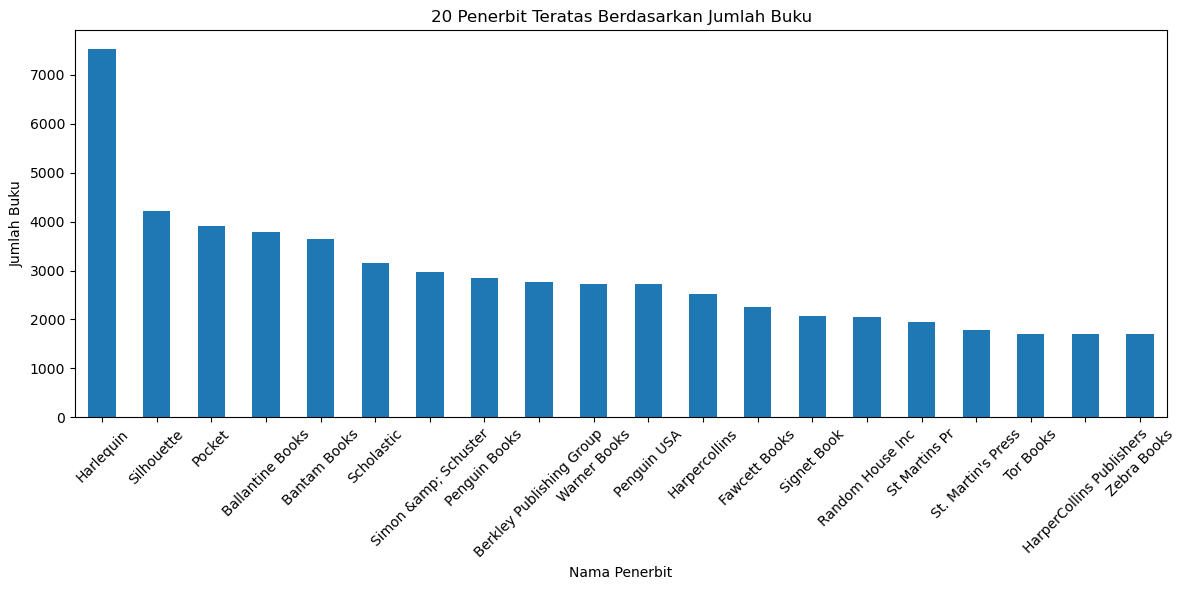

In [90]:
# Grouping'Publisher' dan hitung jumlah buku yang dipublikasi oleh masing-masing penerbit
publisher_counts = books.groupby('Publisher')['Publisher'].count()
# Urutkan penerbit dalam urutan menurun
sorted_publisher = publisher_counts.sort_values(ascending=False)
# Pilih 20 penerbit teratas
top_20_publisher = sorted_publisher.head(20)
# Plot 20 penerbit teratas dan buku yang diterbitkan oleh penerbit kemudian dihitung menggunakan plot batang
plt.figure(figsize=(12, 6))
top_20_publisher.plot(kind='bar')
plt.xlabel('Nama Penerbit')
plt.ylabel('Jumlah Buku')
plt.title('20 Penerbit Teratas Berdasarkan Jumlah Buku')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Setelah menjalankan kode di atas dapat dilihat bahwa Penerbit Harlequin menerbitkan paling banyak buku yaitu sebanyak > 7000 buku.

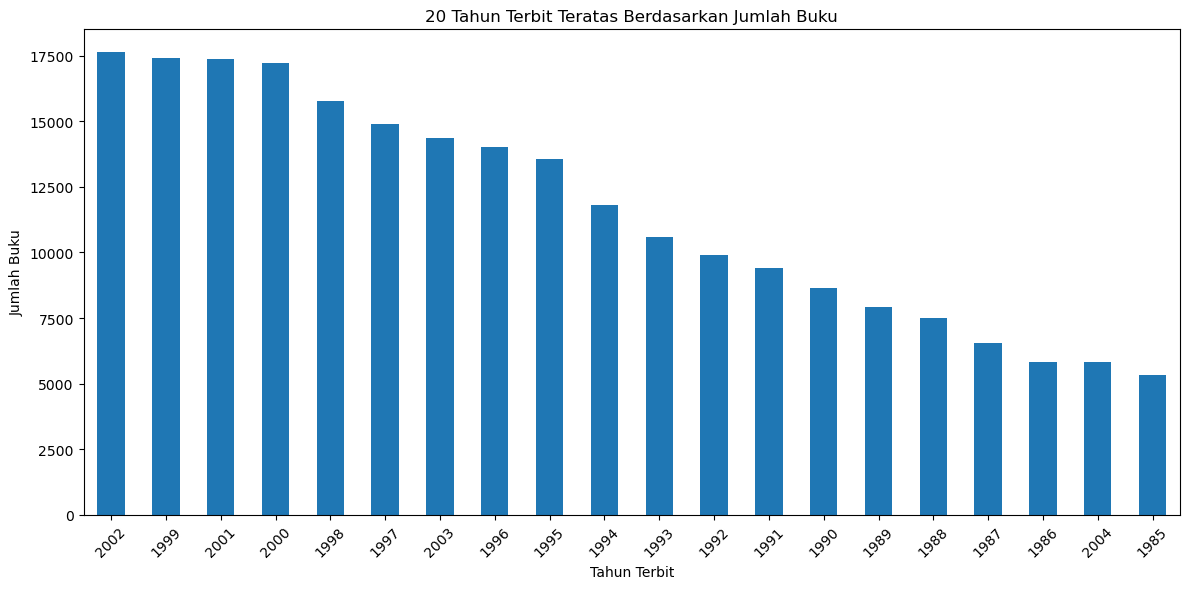

In [91]:
# Grouping'Year-Of-Publication' dan hitung jumlah buku yang dipublikasi oleh masing-masing tahun terbit
year_of_publication_counts = books.groupby('Year-Of-Publication')['Year-Of-Publication'].count()
# Urutkan tahun terbit dalam urutan menurun
sorted_year_of_publication = year_of_publication_counts.sort_values(ascending=False)
# Pilih 20 tahun terbit teratas
top_20_year_of_publication = sorted_year_of_publication.head(20)
# Plot 20 tahun terbit teratas dan buku yang diterbitkan oleh penerbit kemudian dihitung menggunakan plot batang
plt.figure(figsize=(12, 6))
top_20_year_of_publication.plot(kind='bar')
plt.xlabel('Tahun Terbit')
plt.ylabel('Jumlah Buku')
plt.title('20 Tahun Terbit Teratas Berdasarkan Jumlah Buku')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Setelah menjalankan kode di atas dapat dilihat bahwa Tahun Terbit paling banyak menerbitkan buku yaitu pada tahun 2002 sebesar > 17.500 buku.

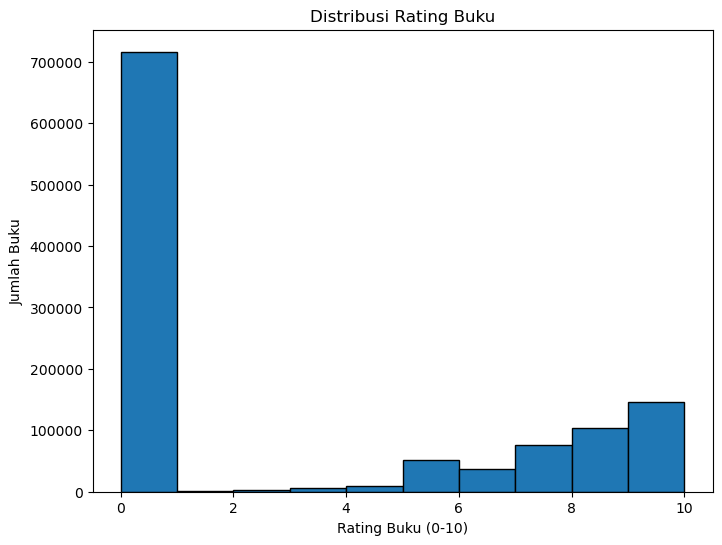

In [92]:
plt.figure(figsize=(8, 6))
plt.hist(ratings['Book-Rating'], bins=10, edgecolor='black')
plt.xlabel('Rating Buku (0-10)')
plt.ylabel('Jumlah Buku')
plt.title('Distribusi Rating Buku')
plt.show()

Setelah menjalankan kode di atas dapat dilihat bahwa rating buku sebagian besar mendapaptkan rating 0.

In [93]:
# Hitung rata-rata rating dari setiap judul buku
mean_rating_by_title = merged_df.groupby('Book-Title')['Book-Rating'].mean()
# Pilih 20 judul buku dengan rata-rata rating terbesar
top_20_titles = mean_rating_by_title.nlargest(20)
top_20_titles

Book-Title
 Dark Justice                                                                                                            10.0
'California Historical Landmarks'                                                                                        10.0
'Isms: a dictionary of words ending in -ism, -ology, and -phobia,: With some similar terms, arranged in subject order    10.0
'Round the Corner (Sister Circle)                                                                                        10.0
006781: Bk.1 Gags De Boule Et Bil                                                                                        10.0
1,000 Makers of the Millennium: The Men and Women Who Have Shaped the Last 1,000 Years                                   10.0
1,001 Computer Hints &amp; Tips: An A-To-Z Guide to Making the Most of Your Computer and the Internet                    10.0
1,001 Things Everyone Should Know About American History                                                   

Setelah menjalankan kode di atas dapat dilihat bahwa berikut merupakan 20 judul buku dengan rata-rata rating terbesar.

In [94]:
# Hitung rata-rata rating dari setiap judul buku
max_rating_by_title = merged_df.groupby('Book-Title')['Book-Rating'].mean()
# Pilih 20 judul buku dengan rata-rata rating terkecil
top_20_titles = max_rating_by_title.nsmallest(20)
top_20_titles

Book-Title
 Always Have Popsicles                                                              0.0
 Apple Magic (The Collector's series)                                               0.0
 Beyond IBM: Leadership Marketing and Finance for the 1990s                         0.0
 Clifford Visita El Hospital (Clifford El Gran Perro Colorado)                      0.0
 Deceived                                                                           0.0
 Harry Potter and the Bible: The Menace Behind the Magick (And the Bible Series)    0.0
 Hiking the California Coastal Trail: Oregon to Monterey                            0.0
 It Takes Two                                                                       0.0
 LA Gallinita Roja/the Little Red Hen                                               0.0
 Mystery Mile                                                                       0.0
 Pokemon: The Official Collector's Sticker Book                                     0.0
 Stories of an Imagin

Setelah menjalankan kode di atas dapat dilihat bahwa berikut merupakan 20 judul buku dengan rata-rata rating terkecil.

## Assessing Data
Tahap selanjutnya adalah Penulis akan mengkaji dataset yang digunakan dalam proyek ini dengan mengecek:
1. Apakah ada missing value?
2. Apakah ada duplikasi?

### Apakah ada missing value?

In [95]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [96]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [97]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

Setelah menjalankan kode di atas, dapat dilihat bahwa dataset `Books.csv` memiliki beberapa *missing value*, jumlah *missing value* yang ada pada kolom:
- `Book-Author` berjumlah 1
- `Publisher` berjumlah 2
- `Image-URL-L` berjumlah 3

Karena jumlahnya relatif sedikit maka pada proyek kali ini akan ditangani dengan cara membuang *missing value* tersebut.

### Apakah ada data duplikat?

In [98]:
books.duplicated().sum()

0

In [99]:
ratings.duplicated().sum()

0

In [100]:
users.duplicated().sum()

0

Setelah menjalankan kode di atas, dapat dilihat bahwa tidak ada data duplikasi pada ketiga dataset yang digunakan dalam proyek ini.

## Menangani Missing Value
Menangani missing value pada dataframe `books`. Karena missing value yang ada pada dataframe relatif sedikit maka pada proyek ini Penulis akan mencoba menerapkan teknik drop pada value tersebut.

In [101]:
books = books.dropna()

In [102]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Karena dataset yang dimiliki sangat banyak dan alokasi memori tidaklah cukup untuk memproses seluruh data, maka di dalam proyek ini Penulis hanya akan mengambil data pertama hingga data ke 20.000 (exclude data ke 20.000).

In [103]:
books = books[:20000]

In [104]:
books.shape

(20000, 8)

In [105]:
books.describe()

,Year-Of-Publication
count,20000.000000
mean,1961.527000
std,257.291152
min,0.000000
25%,1991.000000
50%,1997.000000
75%,2001.000000
max,2011.000000


In [106]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [107]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [108]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
19995,0553801430,By the Light of the Moon,DEAN KOONTZ,2002,Bantam,http://images.amazon.com/images/P/0553801430.0...,http://images.amazon.com/images/P/0553801430.0...,http://images.amazon.com/images/P/0553801430.0...
19996,0066212995,Sleepyhead,Mark Billingham,2002,William Morrow &amp; Company,http://images.amazon.com/images/P/0066212995.0...,http://images.amazon.com/images/P/0066212995.0...,http://images.amazon.com/images/P/0066212995.0...
19997,1402201478,The Last Noel,Michael Malone,2003,Sourcebooks Landmark,http://images.amazon.com/images/P/1402201478.0...,http://images.amazon.com/images/P/1402201478.0...,http://images.amazon.com/images/P/1402201478.0...
19998,0425145662,Joyride,Jack Ketchum,1995,Berkley Publishing Group,http://images.amazon.com/images/P/0425145662.0...,http://images.amazon.com/images/P/0425145662.0...,http://images.amazon.com/images/P/0425145662.0...


Selanjutnya, hal yang perlu dilakukan adalah mengonversi data series menjadi list menggunakan library `tolist()` dari numpy.

In [109]:
isbn = books['ISBN'].tolist()
book_title = books['Book-Title'].tolist()
book_author = books['Book-Author'].tolist()
year_of_publication = books['Year-Of-Publication'].tolist()
publisher = books['Publisher'].tolist()
image_url_s = books['Image-URL-S'].tolist()
image_url_m = books['Image-URL-M'].tolist()
image_url_l = books['Image-URL-L'].tolist()

Tahap berikutnya, hal yang perlu dilakukan adalah membuat *dictionary* untuk menentukan pasangan *key-value* pada dataset books.

In [110]:
books = pd.DataFrame({
    'isbn': isbn,
    'book_title': book_title,
    'book_author': book_author,
    'year_of_publication': year_of_publication,
    'publisher': publisher,
    'image_url_s': image_url_s,
    'image_url_m': image_url_m,
    'image_url_l': image_url_l,
})
books

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
19995,0553801430,By the Light of the Moon,DEAN KOONTZ,2002,Bantam,http://images.amazon.com/images/P/0553801430.0...,http://images.amazon.com/images/P/0553801430.0...,http://images.amazon.com/images/P/0553801430.0...
19996,0066212995,Sleepyhead,Mark Billingham,2002,William Morrow &amp; Company,http://images.amazon.com/images/P/0066212995.0...,http://images.amazon.com/images/P/0066212995.0...,http://images.amazon.com/images/P/0066212995.0...
19997,1402201478,The Last Noel,Michael Malone,2003,Sourcebooks Landmark,http://images.amazon.com/images/P/1402201478.0...,http://images.amazon.com/images/P/1402201478.0...,http://images.amazon.com/images/P/1402201478.0...
19998,0425145662,Joyride,Jack Ketchum,1995,Berkley Publishing Group,http://images.amazon.com/images/P/0425145662.0...,http://images.amazon.com/images/P/0425145662.0...,http://images.amazon.com/images/P/0425145662.0...


# Model Development
---
## TF-IDF Vectorizer
Pada proyek ini, Penulis menggunakan fungsi `tfidfvectorizer()` dari library sklearn.

In [111]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
# Melakukan perhitungan idf pada data `book_author`
tf.fit(books['book_author']) 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out() 

array(['aa', 'aaron', 'aarsen', ..., 'â¼scher', 'â¼skind', 'â¼ter'],
      dtype=object)

Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks.

In [112]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(books['book_author']) 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(20000, 8877)

Perhatikanlah, matriks yang kita miliki berukuran (20000, 8877). Nilai 20000 merupakan ukuran data dan 8877 merupakan matrik nama penulis buku.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi `todense()`. 

In [113]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya mari lihat matriks tf-idf untuk beberapa judul buku dan nama penulis buku.

In [114]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=books.book_title
).sample(10, axis=1,replace=True).sample(10, axis=0)

,leno,franken,diamond,harrar,judd,obstetricians,paula,morash,boeck,books
book_title,,,,,,,,,,
"Puerto Rico Off the Beaten Path, 2nd: A Guide to Unique Places",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The book of laughter and forgetting (Writers from the other Europe),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Motherhood Is Murder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Relatos de Los Inesperado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asking the Right Questions: A Guide to Critical Thinking (6th Edition),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
How Few Remain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amy's Children,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Debt Free!: Your Guide to Personal Bankruptcy Without Shame,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Top Job.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cosine Similarity
Pada tahap sebelumnya, Penulis telah berhasil mengidentifikasi korelasi antara judul buku dan penulis buku. Sekarang, Penulis akan menghitung derajat kesamaan (similarity degree) antar judul buku dengan teknik cosine similarity.

In [115]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [116]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=books['book_title'], columns=books['book_title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap judul buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20000, 20000)


book_title,An Irresistible Impulse,The Twilight of Common Dreams: Why America Is Wracked by Culture Wars,Annie John : A Novel,Schindler's list,Song of Solomon (Oprah's Book Club (Paperback))
book_title,,,,,
Goblins/Whirlwind (X-Files (HarperCollins Age 12-Up)),0.0,0.0,0.0,0.0,0.0
Where the Heart Is,0.0,0.0,0.0,0.0,0.0
The Woman in Black: A Ghost Story,0.0,0.0,0.0,0.0,0.0
Secondary School Teaching: A Guide to Methods and Resources (2nd Edition),0.0,0.0,0.0,0.0,0.0
Diving Bell and the Butterfly,0.0,0.0,0.0,0.0,0.0
Fly Me to the Moon (Zebra Contemporary Romance S.),0.0,0.0,0.0,0.0,0.0
Palomar,0.0,0.0,0.0,0.0,0.0
Babylon Rising,0.0,0.0,0.0,0.0,0.0
Backlash: The Undeclared War Against American Women,0.0,0.0,0.0,0.0,0.0


Dengan cosine similarity, Penulis berhasil mengidentifikasi kesamaan antara satu judul buku dengan judul buku lainnya. Shape (20000, 20000) merupakan ukuran matriks similarity dari data yang dimiliki. Berdasarkan data yang ada, matriks di atas sebenarnya berukuran 20000 judul buku x 20000 judul buku (masing-masing dalam sumbu X dan Y). Artinya, Penulis mengidentifikasi tingkat kesamaan pada 20000 nama judul buku. Tapi tentu Penulis tidak bisa menampilkan semuanya. Oleh karena itu, 20000 hanya memilih 10 judul pada baris vertikal dan 5 judul pada sumbu horizontal seperti pada contoh di atas.
Dengan data kesamaan (similarity) judul buku yang diperoleh dari kode sebelumnya, Penulis akan merekomendasikan judul buku yang mirip (similar) dengan judul buku yang sebelumnya pernah dibaca oleh pengguna.

In [117]:
def content_based_filtering(book_title, top_n=5):
    # Ambil indeks buku di DataFrame
    book_index = books[books['book_title'] == book_title].index[0]
    # Hitung nilai cosine similarity untuk buku tersebut
    similarity_scores = cosine_sim[book_index]
    # Urutkan indeks berdasarkan nilai cosine similarity 
    top_indices = similarity_scores.argsort()[::-1][:top_n+1]
    # Buang input buku yang dimasukan dari rekomendasi
    top_indices = top_indices[top_indices != book_index]
    # Ambil judul buku yang direkomendasikan
    recommended_books = books.loc[top_indices, 'book_title']
    # Hitung nilai kesamaan dari buku-buku tersebut
    similarity_values = similarity_scores[top_indices]
    recommendations_df = pd.DataFrame({'Recommended Books': recommended_books, 'Similarity': similarity_values})
    return recommendations_df

In [118]:
book_title = "Chicken Soup for the Preteen Soul - 101 Stories of Changes, Choices and Growing Up for Kids, ages 10-13"
top_n = 5
recommendations_df = content_based_filtering(book_title, top_n)
recommendations_df

,Recommended Books,Similarity
19447,A 6th Bowl of Chicken Soup for the Soul (Chick...,1.0
12945,Chicken Soup for the Mother's Soul 2 : 101 Mor...,1.0
14474,Chicken Soup for the Soul,1.0
12065,A Second Chicken Soup for the Woman's Soul (Ch...,1.0
19071,Chicken Soup from the Soul of Hawaii: Stories ...,1.0


Sistem berhasil memberikan rekomendasi 5 judul yang mirip dengan input judul buku yang telah dibaca pengguna.

# Evaluation

In [119]:
# Mengubah dataframe ke dalam list
recommended_books = recommendations_df['Recommended Books'].tolist()

# Tagging manual ground truth yang diperlukan
# relevant_books = ["'Chicken Soup for the Golfer's So (Chicken Soup for the Soul)'",
#                   "Chicken Soup from the Soul of Hawaii: Stories of Aloha to Create Paradise Wherever You Are",
#                   "A 6th Bowl of Chicken Soup for the Soul (Chicken Soup for the Soul)"]

# Tagging filtering menggunakan pandas
relevant_books = books[books['book_title'].str.contains("Chicken Soup")]['book_title'].tolist()

## Presisi

In [120]:
def precision_5(recommended_books, relevant_books, k):
    relevant_and_recommended = set(recommended_books).intersection(set(relevant_books)) # Mengambil intersection dari buku yang diprediksi dan ground truth
    precision = len(relevant_and_recommended) / k # Bagi jumlah buku yang relevan dan direkomendasikan dengan jumlah k
    return precision

In [121]:
precision = precision_5(recommended_books, relevant_books, top_n)
print("Presisi: ", precision)

Presisi:  1.0


## Recall

In [122]:
def recall_5(recommended_books, relevant_books, k):
    relevant_and_recommended = set(recommended_books).intersection(set(relevant_books)) # Mengambil intersection dari buku yang diprediksi dan ground truth
    recall = len(relevant_and_recommended) / len(relevant_books) # Bagi jumlah buku yang relevan dan direkomendasikan dengan ground truth
    return recall

In [123]:
recall = recall_5(recommended_books, relevant_books, top_n)
print("Recall: ", recall)

Recall:  0.13157894736842105


## MAP@5

In [124]:
def map_5(recommended_books, relevant_books, k):
    relevant_and_recommended = set(recommended_books[:k]).intersection(set(relevant_books))
    # Hitung AP
    # Sum setiap nilai presisi
    # Bagi dengan ground truth
    average_precision = sum([precision_at_k(recommended_books, relevant_books, i+1) for i in range(k) if recommended_books[i] in relevant_books]) / len(relevant_books)
    return average_precision

In [125]:
mean_average_precision = map_5(recommended_books, relevant_books, top_n)
print("MAP@5: ", mean_average_precision)

MAP@5:  0.13157894736842105
